In [43]:
import os
# Limit the number of CPUs used to 2
os.environ["OMP_NUM_THREADS"] = "5"


import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import argparse
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from torch.nn import Module
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
import scipy.stats.mstats as mstats
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
import traceback
import copy

In [2]:
os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)

from funcs.imgproc import rand_img_list, show_stim, get_imgs_designmx

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


In [64]:
# Manually define the args.
cnn_layer = 9
start = 2000
end = 2200
batch_size = 200
subject = 'subj01'

In [65]:
#  Load the pretrained AlexNet model
model = models.alexnet(pretrained=True)
model.eval()  # Set the model to evaluation mode

class ImageDataset(Dataset):
    def __init__(self, image_ids, transform=None):
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        imgnp = (show_stim(img_no=img_id, hide='y', small = 'y')[0])[163:263,163:263]
        
        imgPIL = Image.fromarray(imgnp) # Convert into PIL from np

        if self.transform:
            imgPIL = self.transform(imgPIL)

        return imgPIL
    
preprocess = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])

train_nodes, _ = get_graph_node_names(model)
print(train_nodes)
this_layer = train_nodes[cnn_layer + 1]
# Which layer to extract the features from # Also add this as argparse thing.
# model_layer = "features.2" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [66]:
feature_extractor = create_feature_extractor(model, return_nodes=[this_layer])

In [67]:
image_ids = get_imgs_designmx()[subject][start:end]
dataset = ImageDataset(image_ids, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

(-0.5, 223.5, 223.5, -0.5)

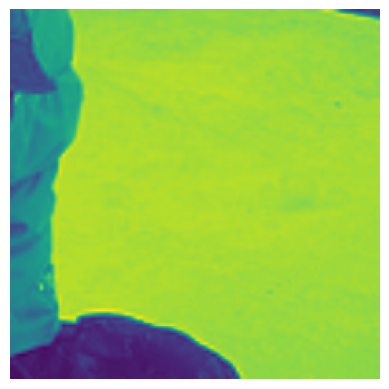

In [68]:
testimg = (dataset.__getitem__(0))
plt.imshow(testimg[0,:,:])
plt.axis('off')

In [69]:
# def fit_pca(feature_extractor, dataloader):
#     # Define PCA parameters
#     pca = IncrementalPCA(n_components=100, batch_size=batch_size)

#     while True:  # Keep trying until successful
#         try:
#             # Fit PCA to batch
#             for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
#                 # Extract features
#                 ft = feature_extractor(d)
#                 # Flatten the features
#                 ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
#                 if np.isnan(ft.detach().numpy().any()):
#                     raise ValueError("Nan value detected before PCA fit")
#                 # Fit PCA to batch
#                 pca.partial_fit(ft.detach().cpu().numpy())
#             return pca  # Return the PCA object
#         except Exception as e:
#             print(f"Error occurred: {e}")
#             print("Restarting PCA fitting...")

def fit_pca(feature_extractor, dataloader):
    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=batch_size)

    while True:  # Keep trying until successful
        try:
            # Fit PCA to batch
            for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
                # Extract features
                ft = feature_extractor(d)
                # Flatten the features
                ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
                if np.isnan(ft.detach().numpy().any()):
                    raise ValueError("Nan value detected before PCA fit")
                # Print out some summary statistics of the features
                print(f'Mean: {ft.mean()}, Std: {ft.std()}, Min: {ft.min()}, Max: {ft.max()}')
                # Fit PCA to batch
                pca.partial_fit(ft.detach().cpu().numpy())
            return pca  # Return the PCA object
        except Exception as e:
            print(f"Error occurred: {e}")
            print("Restarting PCA fitting...")

In [70]:
pca = fit_pca(feature_extractor, dataloader)

  0%|          | 0/1 [00:00<?, ?it/s]

Mean: 0.38151824474334717, Std: 0.9426115155220032, Min: 0.0, Max: 34.400482177734375


100%|██████████| 1/1 [00:10<00:00, 10.65s/it]


In [71]:
def extract_features(feature_extractor, dataloader, pca):
    while True:  # Keep trying until successful
        try:
            features = []
            for i, d in tqdm(enumerate(dataloader), total=len(dataloader)):
                # Extract features
                ft = feature_extractor(d)
                # Flatten the features
                ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])

                # Print out some summary statistics of the features
                print(f'Mean: {ft.mean()}, Std: {ft.std()}, Min: {ft.min()}, Max: {ft.max()}')

                # Check if the features contain NaN values
                if np.isnan(ft.detach().numpy()).any():
                    raise ValueError("NaN value detected")
                
                # Apply PCA transform
                ft = pca.transform(ft.cpu().detach().numpy())
                features.append(ft)
            return np.vstack(features)  # Return the features
        except ValueError as e:
            print(f"Error occurred: {e}")
            print("Restarting feature extraction...")

In [72]:
features_algo = extract_features(feature_extractor, dataloader, pca)

100%|██████████| 1/1 [00:05<00:00,  5.15s/it]

Mean: 0.38151824474334717, Std: 0.9426115155220032, Min: 0.0, Max: 34.400482177734375


In [77]:
def inspect_dat(data):
    print(f'Lowest value: {np.min(data)}')
    print(f'Highest value: {np.max(data)}')
    print(f'Mean value: {np.mean(data)}')
    print(f'Standard deviation: {np.std(data)}')
    return 

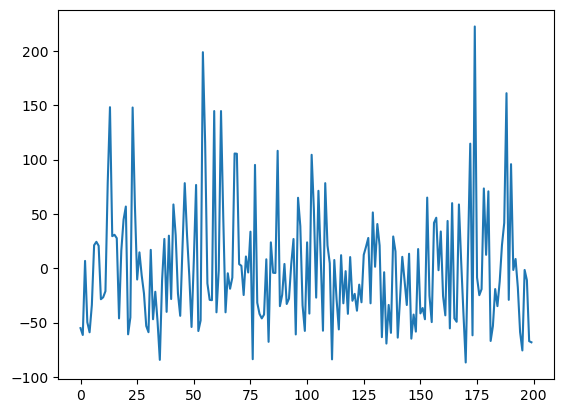

In [73]:
# print (features_algo[:,0])
plt.plot(features_algo[:200,0])





In [176]:
featfull = np.load('/home/rfpred/data/custom_files/subj01/center_strict/cnn_pcs_layerfeatures.3_0-600_fullimg.npz')

feat7 = np.load('/home/rfpred/data/custom_files/subj01/center_strict/cnn_pcs_layerfeatures.7_0-1200.npz')

inspect_dat(feat7['arr_0'])
print(feat7['arr_0'].shape)

feat9 = np.load('/home/rfpred/data/custom_files/subj01/center_strict/alex_lay7.npy')
inspect_dat(feat9)
# okay so these arr_n are the images in the batch.
# inspect_dat(feat9_0['arr_499'])

feat9.shape



Lowest value: -34.71496698159471
Highest value: 80.58866610842563
Mean value: 0.4877497693054282
Standard deviation: 7.053233953831929
(600,)
Lowest value: -21.158131892408896
Highest value: 19.686599471165362
Mean value: 2.9013828376870755e-20
Standard deviation: 1.0000000000000007


(30000, 600)

In [128]:
feat9_0 = np.load('/home/rfpred/data/custom_files/subj01/center_strict/cnn_pcs_layerfeatures.9_1500-2000.npz')
print(len(feat9_0.files))
for i in range(10):
    
    # inspect_dat(feat9_0[f'arr_{i}'])
    
    if (np.isnan(feat9_0[f'arr_{i}']).any()) == True:
        print(i)

500


In [174]:
# Here I stack all the stuff
# if end == 2000:

subject = 'subj01'
cnn_layer = 7
batch_size = 1200
n_comps = 600
prf_region = 'center_strict'

# Calculate total number of arrays across all files
total_arrays = 0
for file_name in sorted(os.listdir(f'/home/rfpred/data/custom_files/{subject}/{prf_region}/')):
    if file_name.startswith(f"cnn_pcs_layerfeatures.{cnn_layer}") and file_name.endswith(".npz"):
        data = np.load(f'/home/rfpred/data/custom_files/{subject}/{prf_region}/{file_name}')
        total_arrays += len(data.files)

# Create layer7_feats with the correct size
layer_feats = np.zeros((total_arrays, n_comps))

n_file = -1
current_array = 0
for file_name in sorted(os.listdir(f'/home/rfpred/data/custom_files/{subject}/{prf_region}/')):
    n_file += 1
    if file_name.startswith(f"cnn_pcs_layerfeatures.{cnn_layer}") and file_name.endswith(".npz"):
        data = np.load(f'/home/rfpred/data/custom_files/{subject}/{prf_region}/{file_name}')
        n_imgs = len(data.files)
        # print(n_imgs)
        
        if n_imgs > 0:
            session_ar = np.zeros((n_imgs, n_comps))
            for image in range(n_imgs):
                # print(f'This is the size of this data: {data[f"arr_{image}"].shape}')
                session_ar[image, :] = get_zscore(data[f'arr_{image}'],print_ars='n')
                if np.isnan(data[f'arr_{image}']).any():
                    print(f'Nan value detected in file {n_file}, image {image}')
                # Print the filename, and image number if the data has values smaller than -10000 or larger than 10000
                if np.min(data[f'arr_{image}']) < -10000 or np.max(data[f'arr_{image}']) > 10000:
                    print(f'Extreme values found in file {file_name}, image number {image}')
                # print(f'Mean: {data[f'arr_{image}'].mean()}, Std: {data[f'arr_{image}'].std()}, Min: {data[f'arr_{image}'].min()}, Max: {data[f'arr_{image}'].max()}')

            layer_feats[current_array:current_array+n_imgs, :] = session_ar
            current_array += n_imgs
            
            

Extreme values found in file cnn_pcs_layerfeatures.7_2400-3600.npz, image number 917


In [152]:
for a in range(10):
    print(a)

0
1
2
3
4
5
6
7
8
9


-2.987485465720018e+36
2.672425510318037e+36
-4.344647808559105
3.9782938235910015


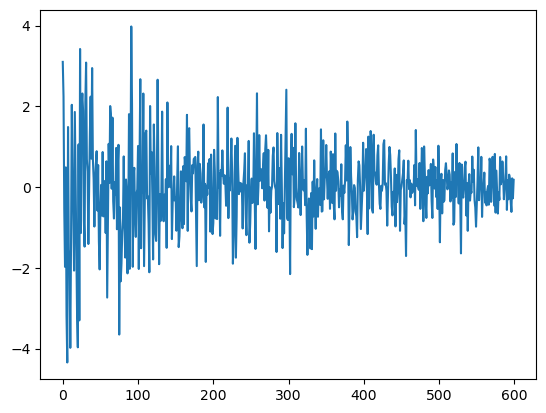

In [172]:
fout = np.load('/home/rfpred/data/custom_files/subj01/center_strict/cnn_pcs_layerfeatures.7_2400-3600.npz')

imgno = 917
print(np.min(fout[f'arr_{imgno}']))
print(np.max(fout[f'arr_{imgno}']))
from funcs.utility import get_zscore
foutfix = get_zscore(fout[f'arr_{imgno}'], print_ars='n')
plt.plot(fout[f'arr_{imgno}'])


print(np.min(foutfix))
print(np.max(foutfix))

plt.plot(foutfix)

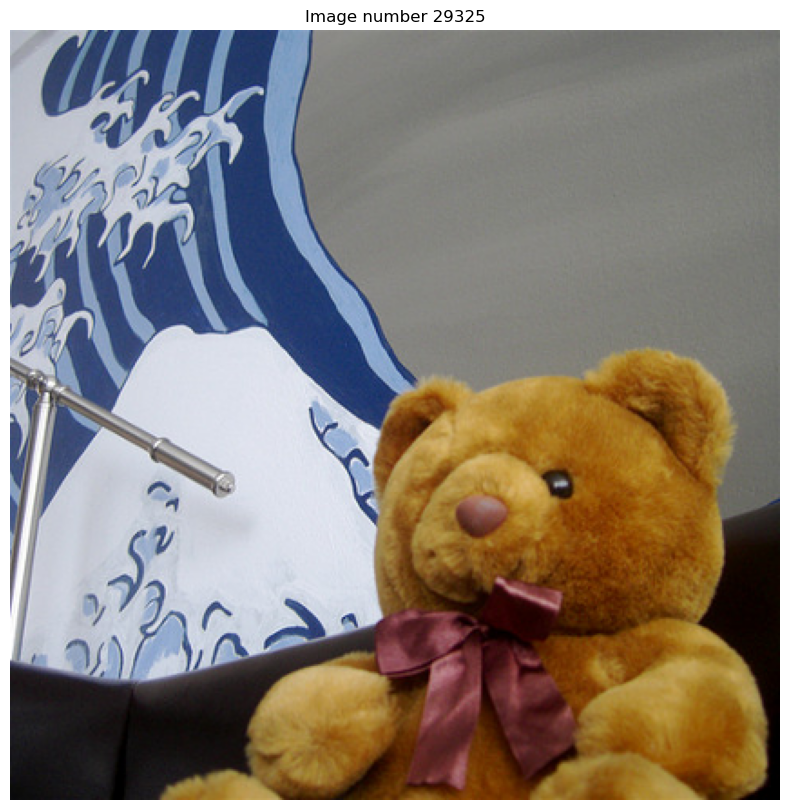

In [169]:
no = get_imgs_designmx()['subj01'][2400+916]
pic = show_stim(img_no=no)

In [175]:
    # if layer_feats.shape == (30000, 600):
    np.save(f'/home/rfpred/data/custom_files/subj01/center_strict/alex_lay{cnn_layer}.npy', layer_feats)
    print(f'Saved yet another collection of extracted features, this time from layer {cnn_layer}')

Saved yet another collection of extracted features, this time from layer 7
